<a href="https://colab.research.google.com/github/meysamsadeghi/ML-with-TensorFlow/blob/master/Veoneer_Innovation_with_Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Veoneer Photo Challenge 2019 - Creating Veonner - Veoneer Innovation*

First, we import the necessary libraries.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
#tf.enable_eager_execution()

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

     |████████████████████████████████| 348.9MB 59kB/s 
     |████████████████████████████████| 501kB 51.2MB/s 
     |████████████████████████████████| 3.1MB 31.3MB/s 


Then, we will define the functions and classes required.

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img


def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  if title:
    plt.title(title)


def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model


def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}
    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    return {'content':content_dict, 'style':style_dict}
  
  
def style_content_loss(outputs, target_styles, target_contents, style_weight, content_weight):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-target_styles[name])**2) 
                          for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-target_contents[name])**2) 
                            for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  return loss


def train_step(image, target_styles, target_contents, extractor, style_weight, content_weight, opt):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs, target_styles, target_contents, style_weight, content_weight)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now we will define the layers from which we will be extracting the the activations to generate a new image with our desired content in the artistic style of interest.

In [0]:
content_layers = ['block5_conv2']
num_content_layers = len(content_layers)
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_style_layers = len(style_layers)

Now we load the content image and a couple of style images.

In [5]:
from google.colab import files
upload_it = files.upload()

Saving content_4.jpg to content_4.jpg
Saving Hokusai_the_greate_wave.jpg to Hokusai_the_greate_wave.jpg
Saving Leonoid_Afremov_Couple_under_one_umbrella.jpg to Leonoid_Afremov_Couple_under_one_umbrella.jpg
Saving Natasha_Wescoat_june_tree.jpg to Natasha_Wescoat_june_tree.jpg
Saving picasso_girl_before_a_mirror.jpg to picasso_girl_before_a_mirror.jpg
Saving picasso_the_three_dancer.jpg to picasso_the_three_dancer.jpg
Saving Van_Gogh_self_portrait.jpg to Van_Gogh_self_portrait.jpg
Saving Van_Gogh_starry_night.jpg to Van_Gogh_starry_night.jpg
Saving Van_Gogh_sun_flower.jpg to Van_Gogh_sun_flower.jpg
Saving Veoneer_listed_NY_stock.jpg to Veoneer_listed_NY_stock.jpg
Saving Wassily_Kandinsky-compositionVII.jpg to Wassily_Kandinsky-compositionVII.jpg


The following function is the main function that receives the content image and style image and generate the desired imag.

In [0]:
def neural_style_transfer(content_str, style_str, style_layers, content_layers):
  content_image = load_img(content_str)
  style_image = load_img(style_str)
  extractor = StyleContentModel(style_layers, content_layers)
  results = extractor(tf.constant(content_image))
  style_results = results['style']
  target_styles = extractor(style_image)['style']
  target_contents = extractor(content_image)['content']

  image = tf.Variable(content_image)
  opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
  style_weight=1e-2
  content_weight=1e4

  epochs = 2
  steps_per_epoch = 1000

  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      train_step(image, target_styles, target_contents, extractor, style_weight, content_weight, opt)
      print(".", end='')
    #display.clear_output(wait=True)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()
    plt.savefig('VNE_NY_Stock_' + style_str)

Now we just need to call the neural_style_transfer function with our content and styleimages.

80142336/80134624 [==============================] - 3s 0us/step


W0829 16:56:14.156357 139707643426688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

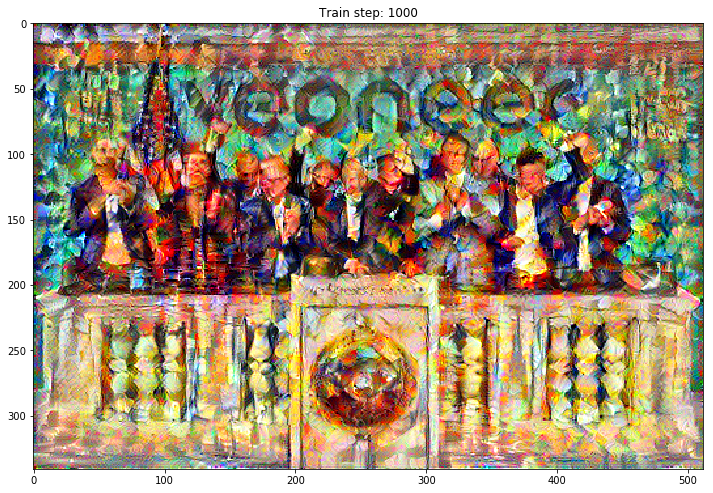

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

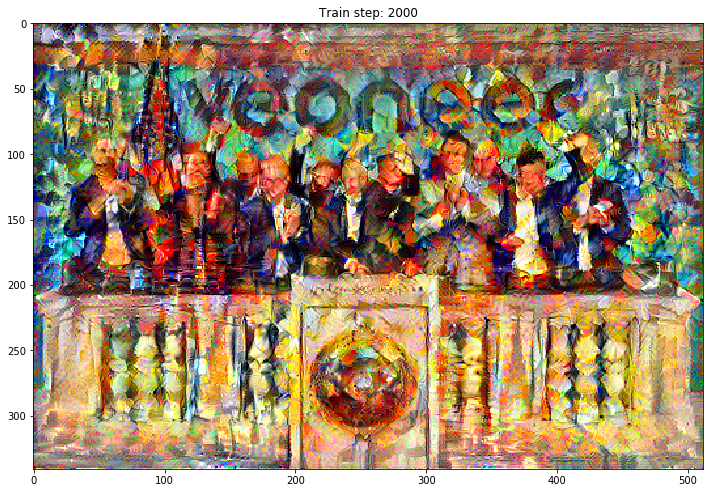

<Figure size 864x864 with 0 Axes>

In [7]:
neural_style_transfer('Veoneer_listed_NY_stock.jpg', 'Leonoid_Afremov_Couple_under_one_umbrella.jpg', style_layers, content_layers)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

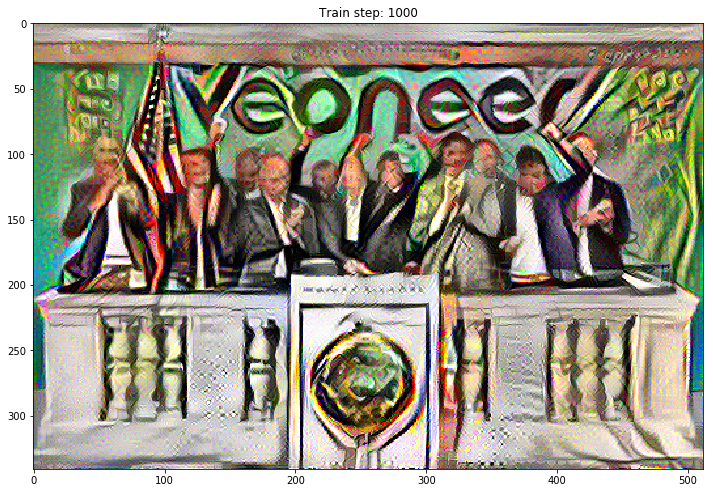

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

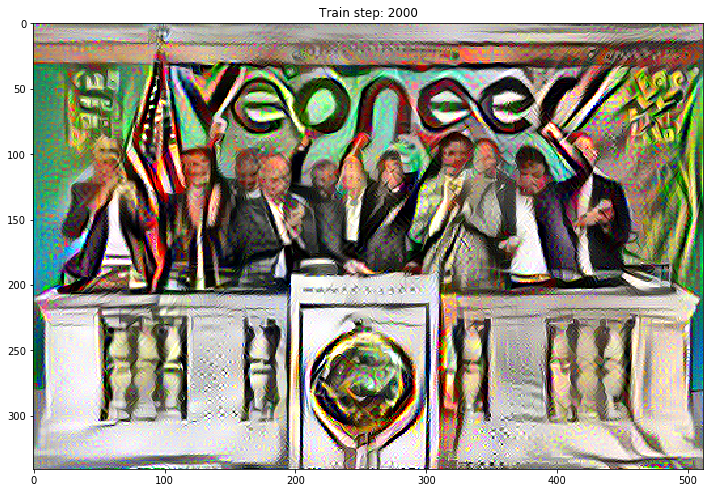

<Figure size 864x864 with 0 Axes>

In [8]:
neural_style_transfer('Veoneer_listed_NY_stock.jpg', 'picasso_girl_before_a_mirror.jpg', style_layers, content_layers)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

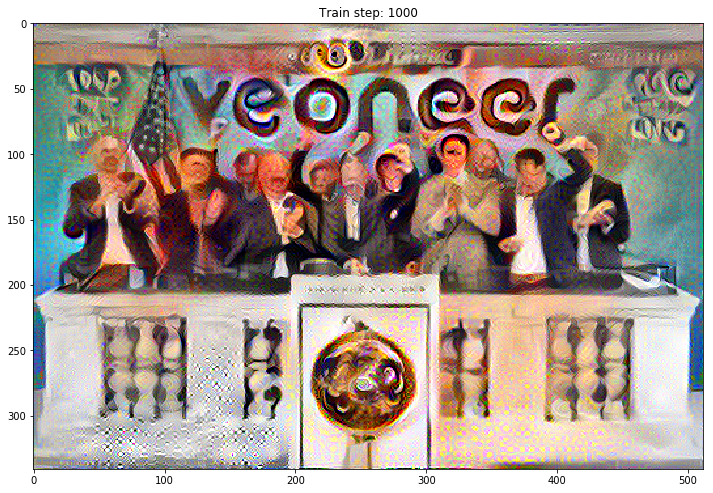

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

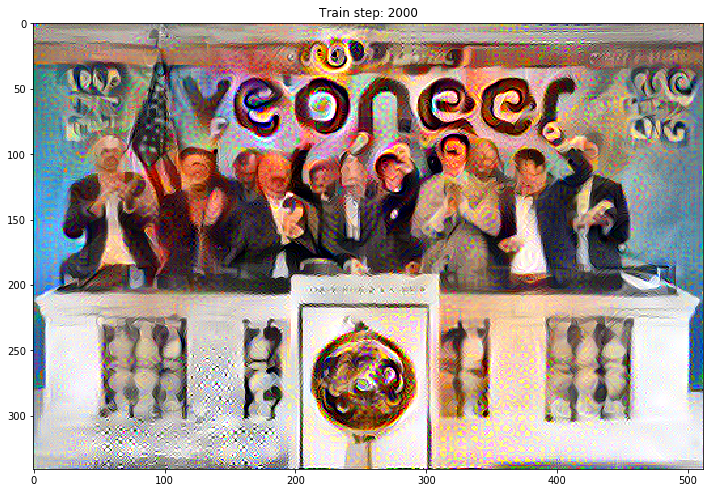

<Figure size 864x864 with 0 Axes>

In [11]:
neural_style_transfer('Veoneer_listed_NY_stock.jpg', 'Natasha_Wescoat_june_tree.jpg', style_layers, content_layers)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

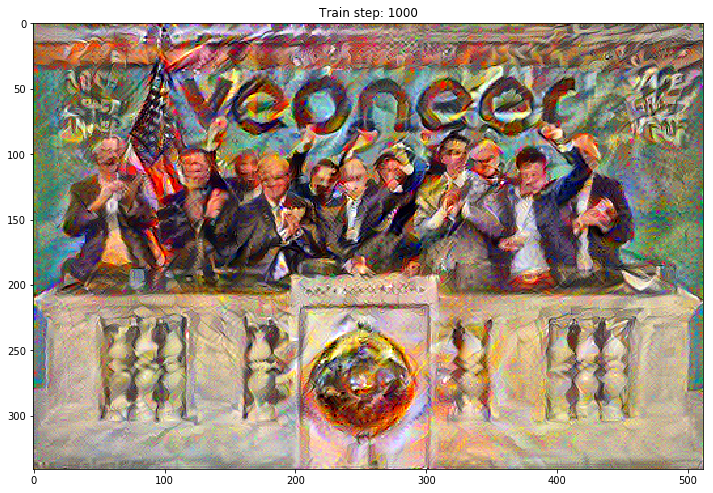

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

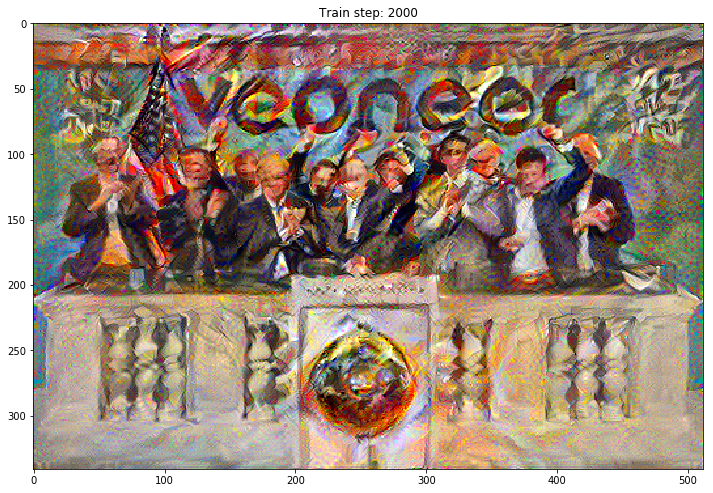

<Figure size 864x864 with 0 Axes>

In [13]:
neural_style_transfer('Veoneer_listed_NY_stock.jpg', 'Wassily_Kandinsky-compositionVII.jpg', style_layers, content_layers)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

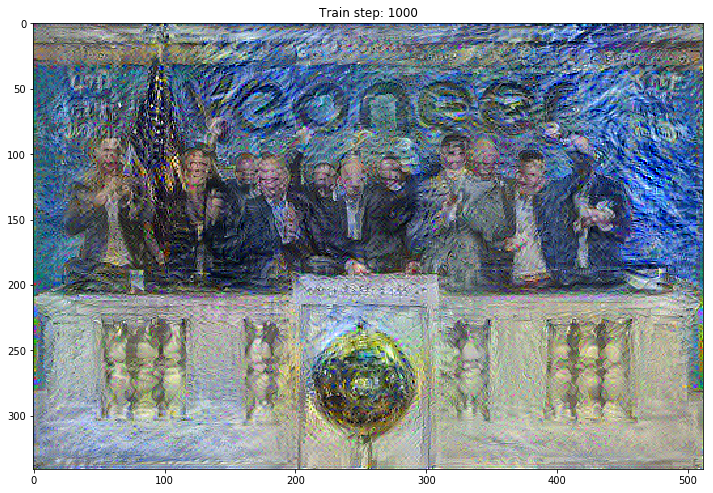

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

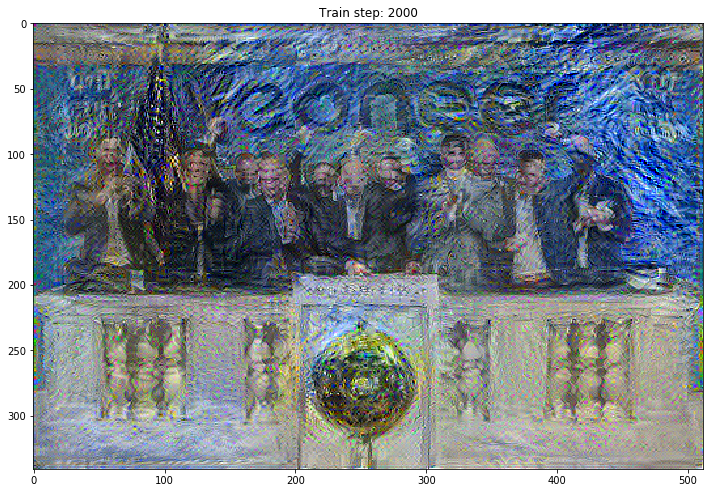

<Figure size 864x864 with 0 Axes>

In [15]:
neural_style_transfer('Veoneer_listed_NY_stock.jpg', 'Van_Gogh_starry_night.jpg', style_layers, content_layers)